## Proyecto

Alumno: [Carlos Adrián Alarcón](https://www.linkedin.com/in/carlos-adrian-alarcon-delgado/)

In [137]:
### Cargar librerías

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


pd.set_option('display.max_columns', None)

In [3]:
### Cargar dataset

data = pd.read_csv("dataset.csv") ### Cambiar path de acuerdo a la ubicación del archivo
data.head()

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.28,3.0014,0.81,0.0,16,Night
1,Winter,6,Clear,2.34,1.9982,0.80,0.0,40,Night
2,Winter,6,Clear,2.34,1.9982,0.80,0.0,32,Night
3,Winter,6,Clear,3.28,3.0014,0.75,0.0,13,Night
4,Winter,6,Clear,3.28,3.0014,0.75,0.0,1,Night


### Perfilamiento de datos

In [4]:
### Número de filas y columnas

print(data.shape)

(17379, 9)


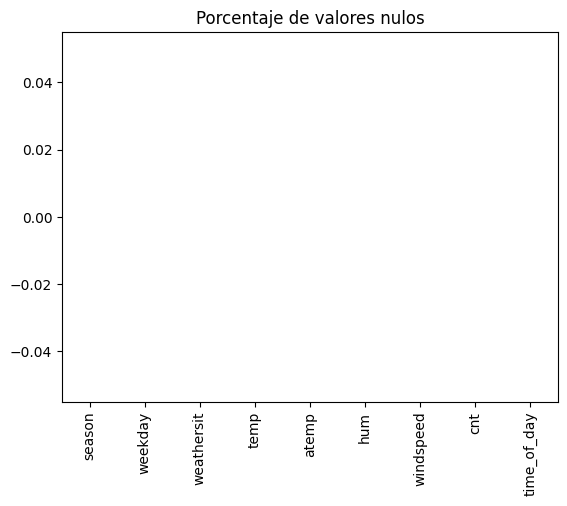

In [5]:
### Buscar valores nulos

data.isnull().mean().plot(kind='bar')
plt.title("Porcentaje de valores nulos")
plt.show()

In [6]:
### Análisis de valores únicos

print(data["season"].unique())
print(data["weekday"].unique())
print(data["weathersit"].unique())

print(data["time_of_day"].unique())

['Winter' 'Spring' 'Summer' 'Fall']
[6 0 1 2 3 4 5]
['Clear' 'Mist' 'Light Rain' 'Heavy Rain']
['Night' 'Morning' 'Evening']


In [7]:
### Estadísticas exploratorias

data.describe()

,weekday,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,3.003683,15.358397,15.401157,0.627229,12.736540,189.463088
std,2.005771,9.050138,11.342114,0.192930,8.196795,181.387599
min,0.000000,-7.060000,-16.000000,0.000000,0.000000,1.000000
25%,1.000000,7.980000,5.997800,0.480000,7.001500,40.000000
50%,3.000000,15.500000,15.996800,0.630000,12.998000,142.000000
75%,5.000000,23.020000,24.999200,0.780000,16.997900,281.000000
max,6.000000,39.000000,50.000000,1.000000,56.996900,977.000000


**Conclusiones** 

No se encontraron valores nulos en el dataset considerado. Para validar este supuesto, también se analizaron variables categóricas, en caso haya alguna categoría que indique `vacío` o `nulo`, sin embargo, los valores únicos son los esperados de acuerdo con el diccionario de datos. Por este motivo, se concluye que no hay valores vacíos en las variables categóricas.

Para validar si es que no hay valores nulos en las variables numéricas, se revisaron las estadísticas descriptias de las mismas. En ese sentido, se puede ver que los parámetros están dentro de lo normal (la mínima temperatura es -7 en Celsius, y la sensación de temeperatura es -16, mientras que los máximos son 39 y 50) por lo que se puede considerar que, aunque algunos valores son extremos, estos se encuentran dentro del rango de lo posible. Lo mismo sucede cn la humedad, que presenta valores hasta 1 (o 100%) y la velocidad del viento. Finalmente se puede observar que la variable target no presenta valores negativos.

En vista de todo lo anteriormente mencionado, se puede decir que no hay valores nulos, y que, a pesar de que sí hay valores atípicos, estos se encuentran dentro del rango esperado (o posible), por lo que no se decide eliminar ninguna de estas filas debido a estos motivos.

In [8]:
### Analizar valores duplicados

print(data.duplicated().sum())

42


In [9]:
### Eliminar valores duplicados

data = data.drop_duplicates()
# Nuevo shape
print(data.shape)

(17337, 9)


**Conclusiones**

Se puede observar que hay 42 filas repetidas exactamente (es decir, con los mismos valores), lo cual, es altamente improbable, por lo que se decide eliminar aquellos registros duplicados. Después de esta operación, el dataset pasa a tener 17337 observaciones de las 17379 que tenía inicialmente

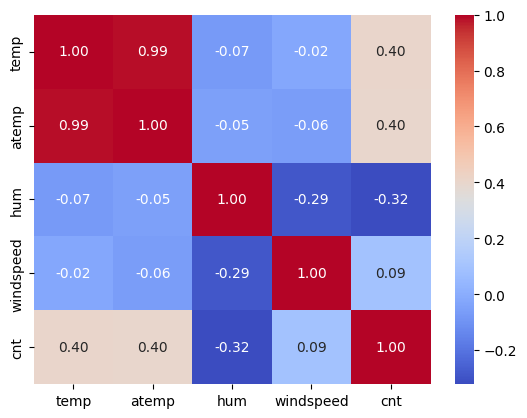

In [10]:
### Análisis de correlación

variables_numericas = ["temp", "atemp", "hum", "windspeed","cnt"]
correlacion = data[variables_numericas].corr()
sns.heatmap(correlacion, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif_data = pd.DataFrame()
vif_data['Variable'] = variables_numericas


vif_data['VIF'] = [variance_inflation_factor(data[variables_numericas].values, i) for i in range(data[variables_numericas].shape[1])]
vif_data


,Variable,VIF
0,temp,142.823211
1,atemp,108.402115
2,hum,4.599099
3,windspeed,3.313092
4,cnt,2.548875


Las variables que se pretenden usar como predictoras no presentan alta correlación con la variable target, ni con otras predictoras, sin embargo, el factor de inflación de varianza sugiere que las variables `temp` y `atemp` podrían presentar multicolinealidad. Analizando lo que representan esas variables, hace sentido que estén con multicolinealidad. En ese sentido, se realizarán experimentos con las dos variables juntas y cada uno por separado, para los dos modelos solicitados, con el fin de analizar qué modelo es el mejor.

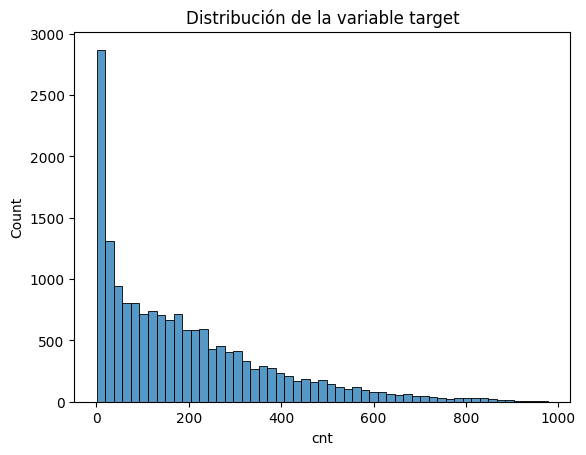

In [12]:
### Distribución de la variable objetivo

sns.histplot(data["cnt"])
plt.title("Distribución de la variable target")
plt.show()

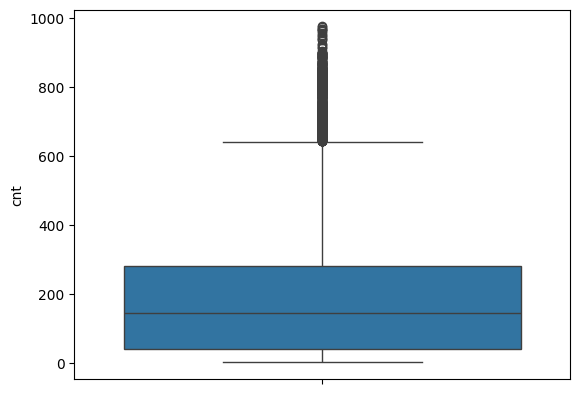

In [26]:

sns.boxplot(data["cnt"])
plt.show()

**Conclusiones**

Se puede observar que la variable target está sesgada hacia la derecha, por lo que cuenta con outliers que podrían afectar el desempeño del modelo. En casos como estos, transformaciones del tipo `log` podrían ayudar a mejorar el performance del modelo, por lo que se probarán como parte de la experimentación

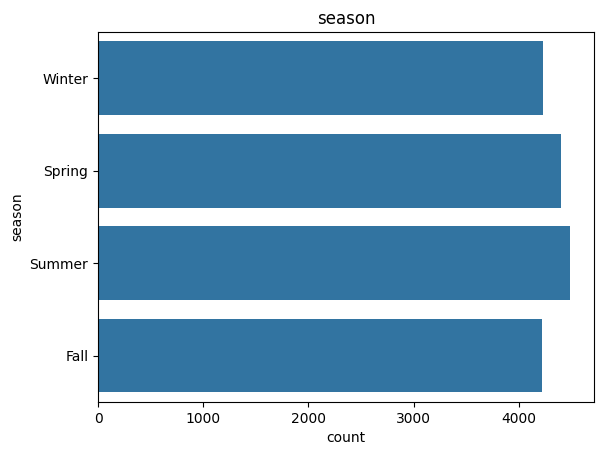

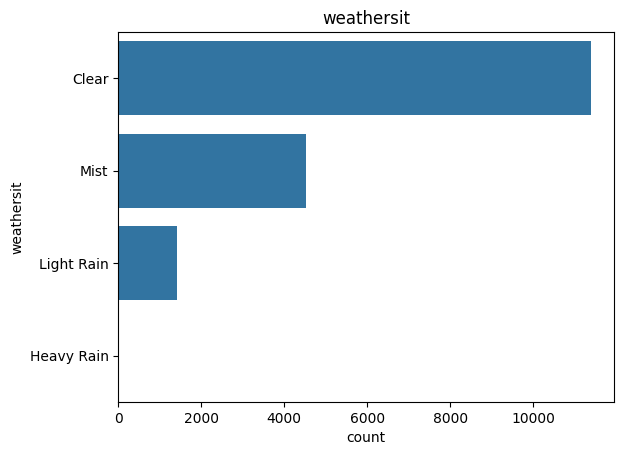

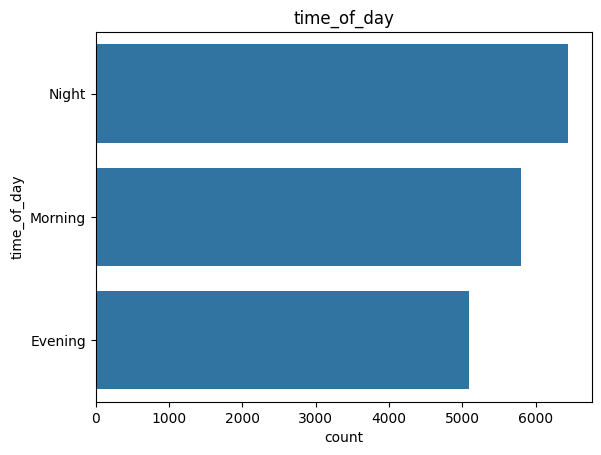

In [14]:
### Distribución de las variables categóricas

variables_categoricas = ["season", "weathersit", "time_of_day"]  
for var in variables_categoricas:
    sns.countplot(data[var])
    plt.title(var)
    plt.show()

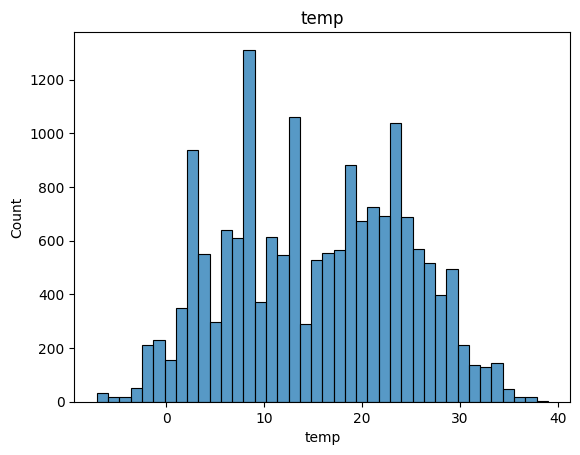

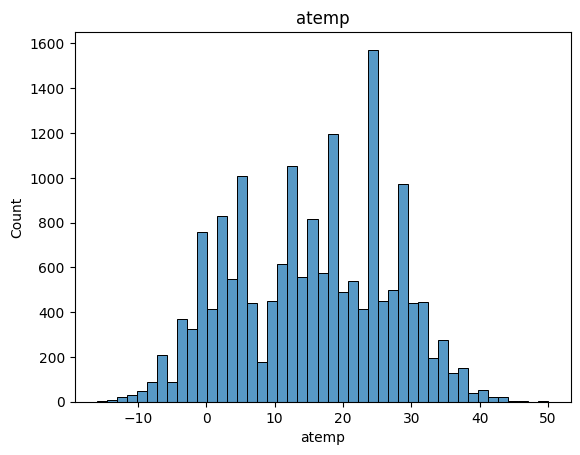

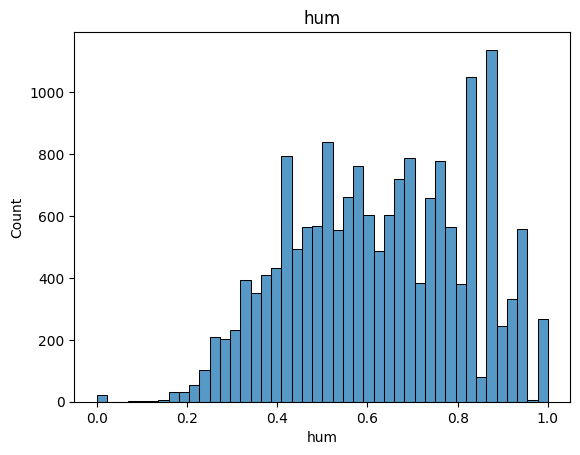

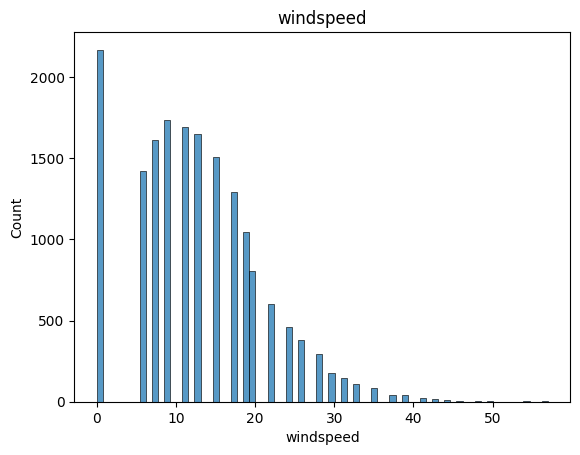

In [15]:
### Distribución de los predictores numéricos
predictores_numericos = ["temp", "atemp", "hum", "windspeed"]
for var in predictores_numericos:
    sns.histplot(data[var])
    plt.title(var)
    plt.show()

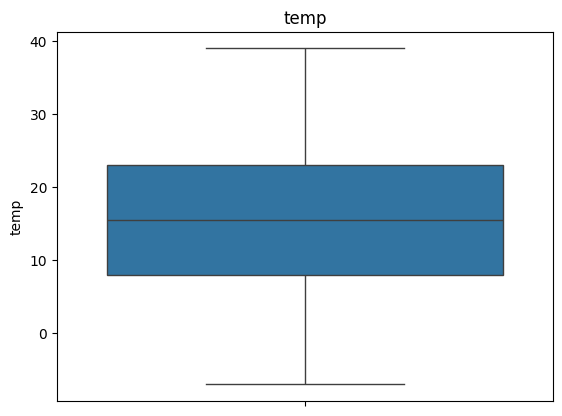

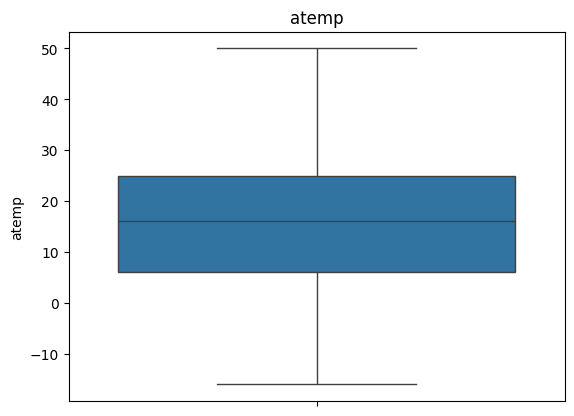

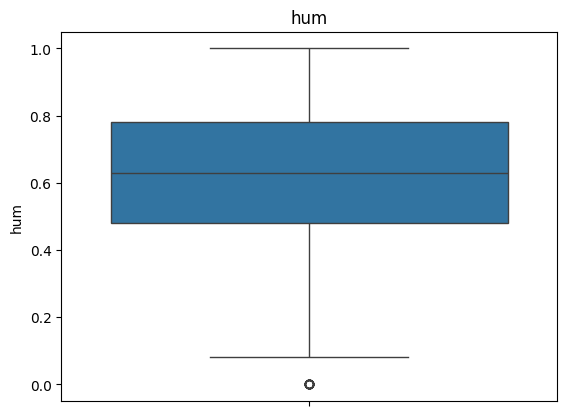

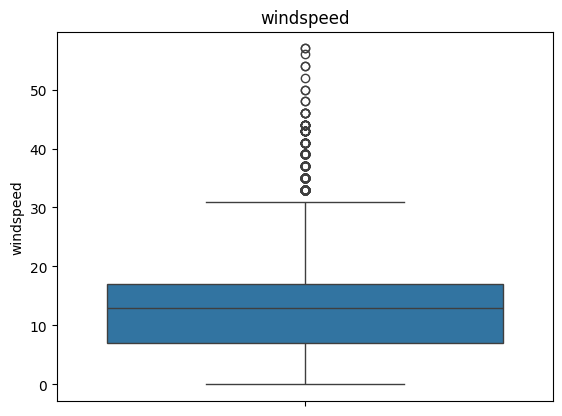

In [16]:
### Analizando outliers

for var in predictores_numericos:
    sns.boxplot(data[var])
    plt.title(var)
    plt.show()

**Conclusión**

Se puede observar que, dentro de las variables categóricas, la mayoría de ellas se distribuyen equitativamente, excepto por la variable `weathersit`, que presenta una menor frecuencia en el valor `heavy_rain`, sin embargo, esto se entiendo debido a que días con lluvía intensa son, justamente, excepcionales.

Con respecto a las variables numéricas, se puede observar que las variables `temp`, `atemp`, y `hum` presentan distribuciones más o menos normales (no es de sorprender que las variables `temp` y `atemp` tengan una distribución similar debido a que están correlacionadas). La variable `windspeed` presenta una distribución sesgada hacia la derecha, sin embargo, es esperable que sean pocos los días en los que se presentan vientos fuertes, por lo que, tal como se indicó anteriormente, los outliers son esperados y posibles en la vida real.

En ese sentido, después de eliminar los duplicados, no se sugiere ningun paso de preprocesamiento adicional; sin embargo, el EDA arroja que, dentro del modelo se deberán experimentar con la exclusión de `atemp` debido a la posible multicolinealidad, además de, también, poder experimentar con la transformación `log` para la variable target. En ese sentido, el listado de experimentos, de acuerdo con los lineamientos del proyecto y lo visto en el EDA sería el siguiente:

* Modelo incluyendo la variable `atemp`
* Modelo excluyendo la variable `atemp`
* Modelo con transformación `log` en el target

Estos experimentos serán realizados para cada uno de los algoritmos requeridos (`polinomial_regressor` y `lasso_regressor`)

### Modelamiento

In [40]:
#### Convertir variables de acuerdo con el tipo correcto
#### Strings para variables categóricas, float para variables numéricas
tipos_datos = {
    'season': 'string',
    'weekday': 'string',
    'weathersit': 'string',
    'temp': 'float',
    'atemp' : 'float',
    'hum' : 'float',
    'windspeed' : 'float',
    'time_of_day' : 'string',
    'cnt' : 'float'
}
def convertir_tipo_datos(
    df : pd.DataFrame, 
    data_types : dict
    ):
    return df.astype(data_types)

data = convertir_tipo_datos(data, tipos_datos)

In [41]:
x = data.drop(columns=["cnt"])
y = data["cnt"]

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=77)
print(x_train.shape)
print(x_test.shape)

(13869, 8)
(3468, 8)


Se decide conservar un 20% de datos para el test debido a que es una muestra representativa para evaluar adecuadamente el modelo, y que, además, dejaría suficientes datos para realizar una correcta validación cruzada con 5 Folds (esto dejaría que cada fold tenga aproximadamente 2773 datos, lo que permitiría una adecuada evaluación). En resumen, la estrategía de evaluación del modelo es la siguiente:

* Test: 20% (3468 datos)
* Train: 80% (13869 datos). Se aplicará KFold validation con 5 folds para calibrar hiperparámetros y asegurar generalización y evitar sobreajuste.

### Regresión Polinomial

In [53]:
### Funciones de modelamiento
def identificar_tipos_variables(
        df : pd.DataFrame
    ):

    var_cat = [col for col in df.columns if pd.api.types.is_string_dtype(df[col])]
    var_num = [col for col in df.columns if pd.api.types.is_float_dtype(df[col])]
    return var_cat, var_num

def calibracion_hiperparametros_polinomial(
        x : pd.DataFrame,
        y : pd.DataFrame,
        params : dict = {'preprocessor__num__polynomial__degree': [2, 3]},
        n_fold : int = 5,
        log_transformation : bool = False
    ):

    var_cat, var_num = identificar_tipos_variables(x)
    
    numeric_transformer = Pipeline(
        steps=[("polynomial", PolynomialFeatures())]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, var_num),
            ("cat", categorical_transformer, var_cat),
        ]
    )

    modelo_polinomial = Pipeline(
        steps=[
            ("preprocessor", preprocessor), 
            ("scaler", RobustScaler()),
            ("regressor", LinearRegression())]
    )

    if log_transformation:
        modelo_polinomial = TransformedTargetRegressor(
            regressor=modelo_polinomial,
            func = np.log,
            inverse_func=np.exp
        )

    kfold = KFold(n_splits=n_fold, shuffle=True, random_state=77)
    modelos_grid = GridSearchCV(modelo_polinomial, params, cv=kfold, n_jobs=-1)
    modelos_grid.fit(x_train, y_train)
    return modelos_grid.best_params_

In [127]:
### Encontrar los mejores parámetros para cada experimento

params_exp_1 = calibracion_hiperparametros_polinomial(x_train, y_train)
params_exp_2 = calibracion_hiperparametros_polinomial(x_train[
    [
        'season', 
        'weekday', 
        'weathersit', 
        'temp',
        'hum', 
        'windspeed',
        'time_of_day'
        ]
       ], 
       y_train
       )
params_exp_3 = calibracion_hiperparametros_polinomial(
    x_train, 
    y_train, 
    params = {'regressor__preprocessor__num__polynomial__degree': [2, 3]}, 
    log_transformation=True
    )
params_exp_4 = calibracion_hiperparametros_polinomial(x_train[
    [
        'season', 
        'weekday', 
        'weathersit', 
        'temp', 
        'hum', 
        'windspeed',
        'time_of_day'
        ]
       ], 
       y_train,
       params = {'regressor__preprocessor__num__polynomial__degree': [2, 3]}, 
        log_transformation=True
       )
print("Params Exp1:",params_exp_1)
print("Params Exp2:",params_exp_2)
print("Params Exp3:",params_exp_3)
print("Params Exp4:",params_exp_4)

Params Exp1: {'preprocessor__num__polynomial__degree': 3}
Params Exp2: {'preprocessor__num__polynomial__degree': 3}
Params Exp3: {'regressor__preprocessor__num__polynomial__degree': 2}
Params Exp4: {'regressor__preprocessor__num__polynomial__degree': 2}


In [115]:
#### Validación cruzada

def validacion_cruzada(
        x,
        y,
        params,
        n_fold = 5,
        log_transformation = False
    ):
    best_param = list(params.values())[0]
    var_cat, var_num = identificar_tipos_variables(x)

    numeric_transformer = Pipeline(
        steps=[("polynomial", PolynomialFeatures(degree=best_param))]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, var_num),
            ("cat", categorical_transformer, var_cat),
        ]
    )


    modelo_polinomial = Pipeline(
        steps=[
            ("preprocessor", preprocessor), 
            ("scaler", RobustScaler()),
            ("regressor", LinearRegression())]
    )

    if log_transformation:
        modelo_polinomial = TransformedTargetRegressor(
            regressor=modelo_polinomial,
            func = np.log,
            inverse_func=np.exp
        )

    kfold = KFold(n_splits=n_fold, shuffle=True, random_state=77)

    resultados = cross_validate(
        modelo_polinomial, 
        x, 
        y, 
        cv=kfold, 
        scoring="neg_root_mean_squared_error",
        return_train_score=True)

    return resultados

def obtener_metricas(
        metricas, 
        dibujar = True,
        titulo = None
    ):

    eje_x = np.arange(1, len(metricas["train_score"])+1)
    resultados_exp = {
        "Avg RMSE Train" : np.mean(-metricas["train_score"]),
        "Std RMSE Train" : np.std(-metricas["train_score"]),
        "Avg RMSE Val" : np.mean(-metricas["test_score"]),
        "Std RMSE Val" : np.std(-metricas["test_score"]),
     }

    if dibujar:
        fig, ax = plt.subplots(ncols = 2)
        y_train = -metricas["train_score"]
        y_val = -metricas["test_score"]
        ymin = 0
        ymax = max(y_train.max(), y_val.max()) + 5
        sns.barplot(
            x = eje_x,
            y = -metricas["train_score"],
            color = "blue",
            ax = ax[0]
        )
        ax[0].set_ylim(ymin, ymax) 
        sns.barplot(
            x = eje_x,
            y = -metricas["test_score"],
            color = "skyblue",
            ax = ax[1]
        )
        ax[0].set_title("RMSE Entrenamiento")
        ax[1].set_title("RMSE Validación")
        ax[1].set_ylim(ymin, ymax) 
        plt.suptitle(f"Resultados Validación Cruzada {titulo}")
        plt.show()
    return resultados_exp

In [94]:
resultados_exp_1 = validacion_cruzada(x_train, y_train, params_exp_1)
resultados_exp_2 = validacion_cruzada(x_train[
    [
        'season', 
        'weekday', 
        'weathersit', 
        'temp',
        'hum', 
        'windspeed',
        'time_of_day'
        ]
       ], 
       y_train, params_exp_2)
resultados_exp_3 = validacion_cruzada(x_train, y_train, params_exp_3, log_transformation=True)
resultados_exp_4 = validacion_cruzada(x_train[
    [
        'season', 
        'weekday', 
        'weathersit', 
        'temp', 
        'hum', 
        'windspeed',
        'time_of_day'
        ]
       ], 
       y_train, params_exp_4, log_transformation=True)

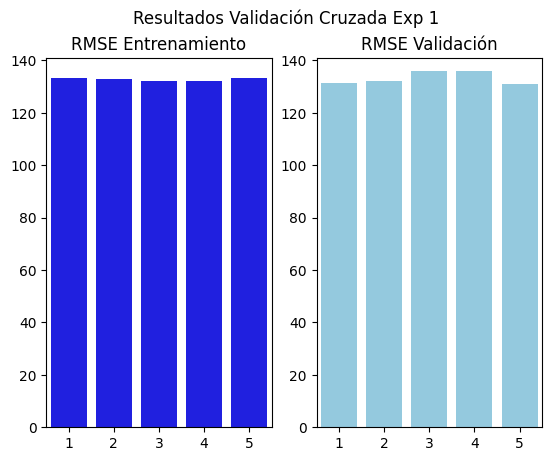

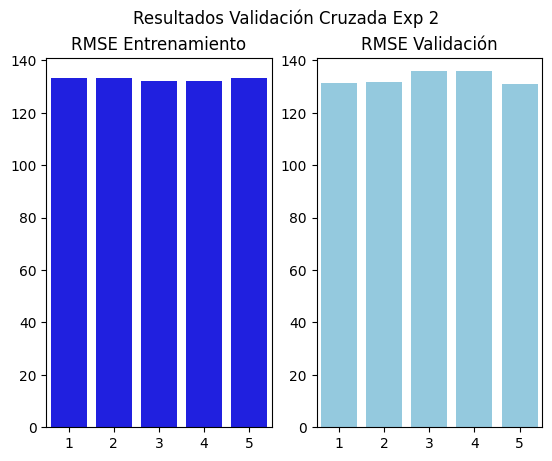

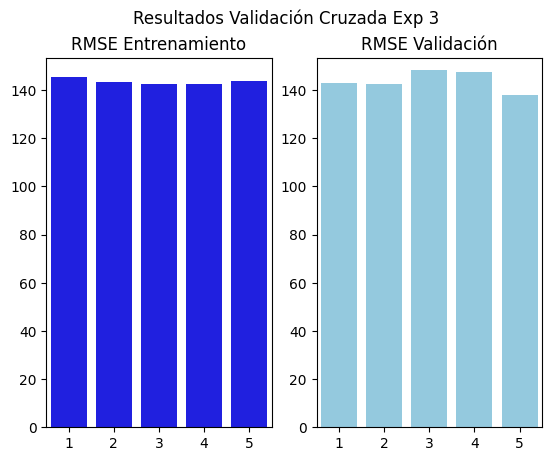

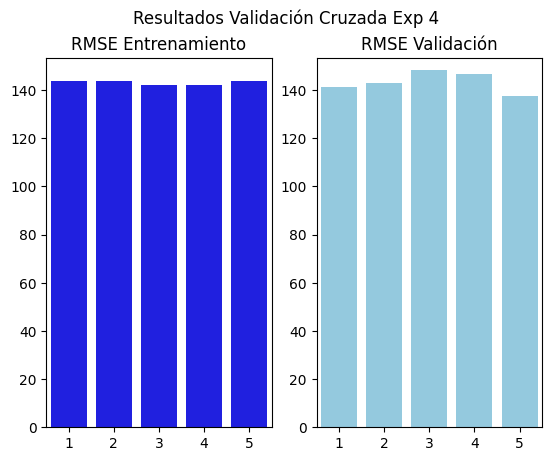

In [117]:
metricas_exp_1 = obtener_metricas(resultados_exp_1, titulo = "Exp 1")
metricas_exp_2 = obtener_metricas(resultados_exp_2, titulo = "Exp 2")
metricas_exp_3 = obtener_metricas(resultados_exp_3, titulo = "Exp 3")
metricas_exp_4 = obtener_metricas(resultados_exp_4, titulo = "Exp 4")


In [126]:
df_metricas_poli = pd.DataFrame(
    {
        "exp1":metricas_exp_1,
        "exp2":metricas_exp_2,
        "exp3":metricas_exp_3,
        "exp4":metricas_exp_4
        }
        )

df_metricas_poli

,exp1,exp2,exp3,exp4
Avg RMSE Train,132.684159,132.825369,143.524086,143.070465
Std RMSE Train,0.572344,0.558852,1.054772,0.763434
Avg RMSE Val,133.222674,133.195736,143.779559,143.301038
Std RMSE Val,2.249905,2.206413,3.843673,3.932625


In [139]:
### Métricas sobre test con respecto al modelo ganador (exp2)
vars = [
        'season', 
        'weekday', 
        'weathersit', 
        'temp', 
        'hum', 
        'windspeed',
        'time_of_day'
        ]

var_cat, var_num = identificar_tipos_variables(x_train[vars])
numeric_transformer = Pipeline(
    steps=[("polynomial", PolynomialFeatures(degree=list(params_exp_2.values())[0]))]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, var_num),
        ("cat", categorical_transformer, var_cat),
    ]
)


modelo_polinomial = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("scaler", RobustScaler()),
        ("regressor", LinearRegression())]
)

modelo_polinomial.fit(x_train, y_train)

preds_polinomial = modelo_polinomial.predict(x_test[vars])

print("RMSE Test:", root_mean_squared_error(y_test, preds_polinomial))
print("R2 Test:", r2_score(y_test, preds_polinomial))
print("MAE Test:", mean_absolute_error(y_test, preds_polinomial))


RMSE Test: 136.33097805194313
R2 Test: 0.44710412161574986
MAE Test: 100.23319246228918


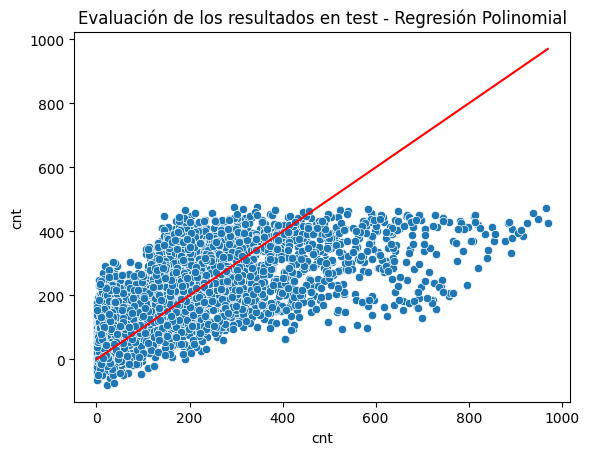

In [136]:
sns.scatterplot(x = y_test, y = preds_polinomial)
sns.lineplot(x = y_test, y = y_test, color = "red")
plt.title("Evaluación de los resultados en test - Regresión Polinomial")
plt.show()

**Conclusiones**

Se puede observar que el experimento 2 es el que presenta un mejor desempeño con respecto a los demás experimentos. Es decir, quitar la variable `atemp` al evitar la multicolinealidad mejora el desempeño del modelo. Asimismo, el mejor parámetro (grado del polinomio) para este modelo es 3. El experimento 2 no incluye una transformación para la variable target. Finalmente, se puede observar que no hay muestras de sobreajuste debido a que los errores de entrenamiento y validación son similares, mostrando un performance con poca variabilidad entre todos los folds evaluados.

Sobre este experimento se realizó la predicción sobre test y se obtuvo un `RMSE` DE 136.33, que es similar al error mostrado en la parte de validación. Con esto, podemos afirmar que hay evidencia suficiente para decir que el modelo generaliza de una manera correcta. Con respecto al `R2` , se puede observar que el modelo explica el 44.7% de la varianza, lo que es relativamente bueno.

En general, se puede decir que es un modelo relativamente bueno, a juzgar por las métricas de test, que no muestra sobreajuste y que generaliza relativamente bien, sin embargo, analizando la distribución de las predicciones y los valores reales, se puede ver que todavía hay algunos valores que no son predichos correctamente. Eso se observa en el `MAE` de 100, que podría ser mejor, considerando que el valor máximo del target actual está rondando los 970

### Lasso

In [148]:
def calibracion_hiperparametros_lasso(
        x : pd.DataFrame,
        y : pd.DataFrame,
        params : dict = {'regressor__alpha': [1, 2, 3, 4, 5]},
        n_fold : int = 5,
        log_transformation : bool = False
    ):

    var_cat, var_num = identificar_tipos_variables(x)
    

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", "passthrough", var_num),
            ("cat", categorical_transformer, var_cat),
        ]
    )

    modelo_lasso = Pipeline(
        steps=[
            ("preprocessor", preprocessor), 
            ("scaler", RobustScaler()),
            ("regressor", Lasso())]
    )

    if log_transformation:
        modelo_lasso = TransformedTargetRegressor(
            regressor=modelo_lasso,
            func = np.log,
            inverse_func=np.exp
        )

    kfold = KFold(n_splits=n_fold, shuffle=True, random_state=77)
    modelos_grid = GridSearchCV(modelo_lasso, params, cv=kfold, n_jobs=-1)
    modelos_grid.fit(x_train, y_train)
    return modelos_grid.best_params_

In [149]:
### Encontrar los mejores parámetros para cada experimento

params_exp_1_lasso = calibracion_hiperparametros_lasso(x_train, y_train)
params_exp_2_lasso = calibracion_hiperparametros_lasso(x_train[
    [
        'season', 
        'weekday', 
        'weathersit', 
        'temp',
        'hum', 
        'windspeed',
        'time_of_day'
        ]
       ], 
       y_train
       )
params_exp_3_lasso = calibracion_hiperparametros_lasso(
    x_train, 
    y_train, 
    params = {'regressor__regressor__alpha': [1, 2, 3, 4, 5]}, 
    log_transformation=True
    )
params_exp_4_lasso = calibracion_hiperparametros_lasso(x_train[
    [
        'season', 
        'weekday', 
        'weathersit', 
        'temp', 
        'hum', 
        'windspeed',
        'time_of_day'
        ]
       ], 
       y_train,
       params = {'regressor__regressor__alpha': [1, 2, 3, 4, 5]}, 
        log_transformation=True
       )
print("Params Exp1:",params_exp_1_lasso)
print("Params Exp2:",params_exp_2_lasso)
print("Params Exp3:",params_exp_3_lasso)
print("Params Exp4:",params_exp_4_lasso)

Params Exp1: {'regressor__alpha': 1}
Params Exp2: {'regressor__alpha': 1}
Params Exp3: {'regressor__regressor__alpha': 1}
Params Exp4: {'regressor__regressor__alpha': 1}


In [150]:
def validacion_cruzada_lasso(
        x,
        y,
        params,
        n_fold = 5,
        log_transformation = False
    ):
    best_param = list(params.values())[0]
    var_cat, var_num = identificar_tipos_variables(x)

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", "passthrough", var_num),
            ("cat", categorical_transformer, var_cat),
        ]
    )

    modelo_lasso = Pipeline(
        steps=[
            ("preprocessor", preprocessor), 
            ("scaler", RobustScaler()),
            ("regressor", Lasso(alpha = best_param))]
    )

    if log_transformation:
        modelo_lasso = TransformedTargetRegressor(
            regressor=modelo_lasso,
            func = np.log,
            inverse_func=np.exp
        )

    kfold = KFold(n_splits=n_fold, shuffle=True, random_state=77)

    resultados = cross_validate(
        modelo_lasso, 
        x, 
        y, 
        cv=kfold, 
        scoring="neg_root_mean_squared_error",
        return_train_score=True)

    return resultados

In [152]:
resultados_exp_1_lasso = validacion_cruzada_lasso(x_train, y_train, params_exp_1_lasso)
resultados_exp_2_lasso = validacion_cruzada_lasso(x_train[
    [
        'season', 
        'weekday', 
        'weathersit', 
        'temp',
        'hum', 
        'windspeed',
        'time_of_day'
        ]
       ], 
       y_train, params_exp_2_lasso)
resultados_exp_3_lasso = validacion_cruzada_lasso(x_train, y_train, params_exp_3_lasso, log_transformation=True)
resultados_exp_4_lasso = validacion_cruzada_lasso(x_train[
    [
        'season', 
        'weekday', 
        'weathersit', 
        'temp', 
        'hum', 
        'windspeed',
        'time_of_day'
        ]
       ], 
       y_train, params_exp_4_lasso, log_transformation=True)

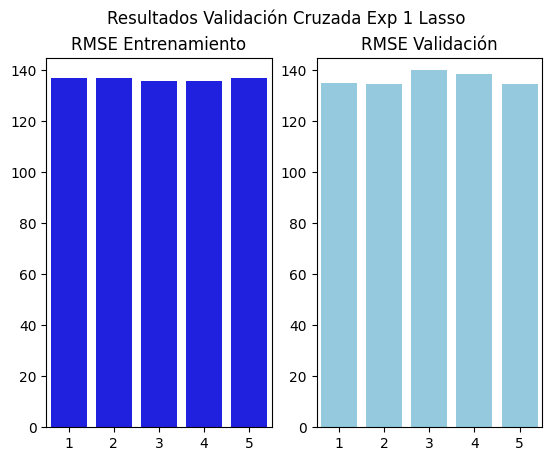

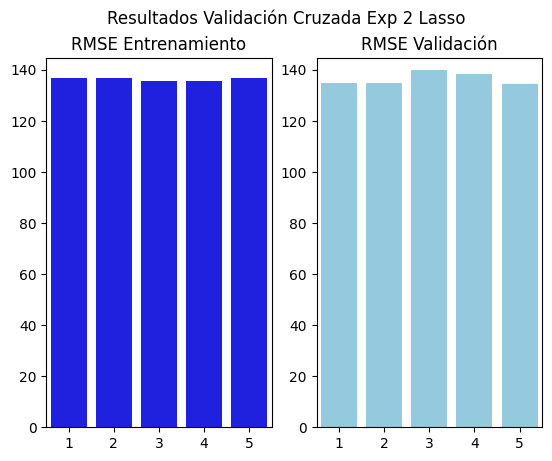

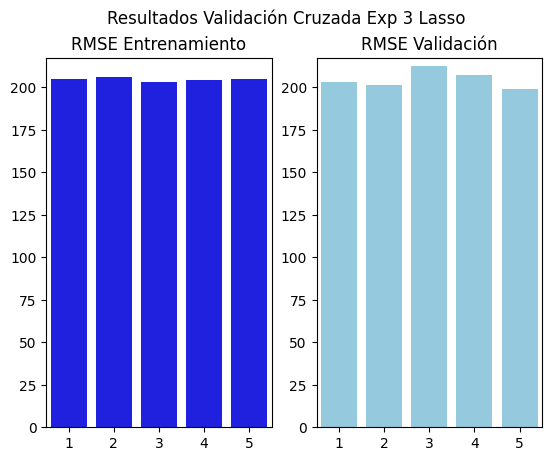

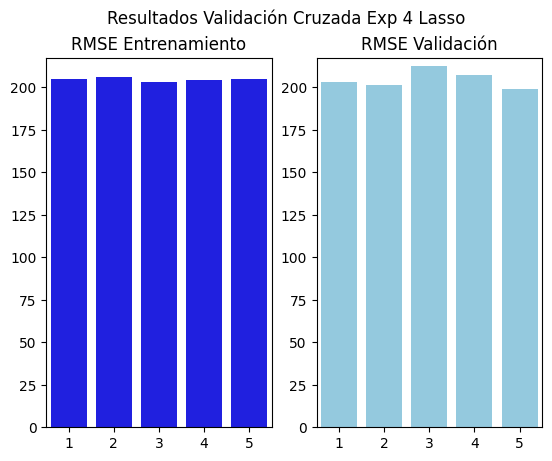

In [153]:
metricas_exp_1_lasso = obtener_metricas(resultados_exp_1_lasso, titulo = "Exp 1 Lasso")
metricas_exp_2_lasso = obtener_metricas(resultados_exp_2_lasso, titulo = "Exp 2 Lasso")
metricas_exp_3_lasso = obtener_metricas(resultados_exp_3_lasso, titulo = "Exp 3 Lasso")
metricas_exp_4_lasso = obtener_metricas(resultados_exp_4_lasso, titulo = "Exp 4 Lasso")

In [154]:
df_metricas_lasso = pd.DataFrame(
    {
        "exp1":metricas_exp_1_lasso,
        "exp2":metricas_exp_2_lasso,
        "exp3":metricas_exp_3_lasso,
        "exp4":metricas_exp_4_lasso
        }
        )

df_metricas_lasso

,exp1,exp2,exp3,exp4
Avg RMSE Train,136.227520,136.261549,204.633936,204.633936
Std RMSE Train,0.544787,0.537883,0.909518,0.909518
Avg RMSE Val,136.366192,136.392380,204.604804,204.604804
Std RMSE Val,2.226167,2.208245,4.648868,4.648868


In [157]:
### Métricas sobre test con respecto al modelo ganador (exp1)

best_param = list(params_exp_1_lasso.values())[0]
var_cat, var_num = identificar_tipos_variables(x_train)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", var_num),
        ("cat", categorical_transformer, var_cat),
    ]
)

modelo_lasso = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("scaler", RobustScaler()),
        ("regressor", Lasso(alpha = best_param))]
    )

modelo_lasso.fit(x_train, y_train)

preds_lasso = modelo_lasso.predict(x_test)

print("RMSE Test:", root_mean_squared_error(y_test, preds_lasso))
print("R2 Test:", r2_score(y_test, preds_lasso))
print("MAE Test:", mean_absolute_error(y_test, preds_lasso))

RMSE Test: 139.76684167977663
R2 Test: 0.4188843726016084
MAE Test: 103.43123241655542


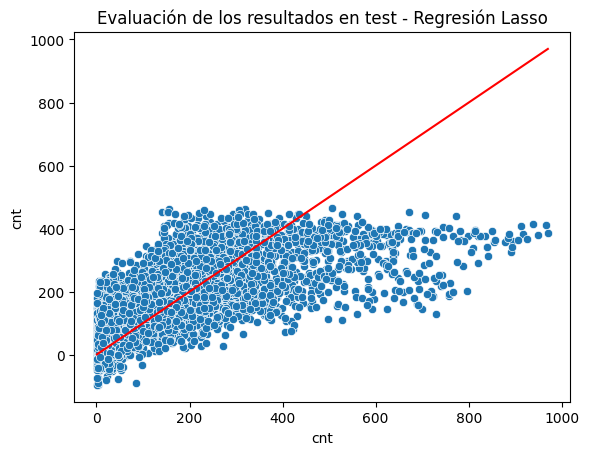

In [158]:
sns.scatterplot(x = y_test, y = preds_lasso)
sns.lineplot(x = y_test, y = y_test, color = "red")
plt.title("Evaluación de los resultados en test - Regresión Lasso")
plt.show()

**Conclusiones**

Se puede observar que el experimento 1 es el que presenta un mejor desempeño con respecto a los demás experimentos, considerando la métrica de validación. Es decir, quitar la variable `atemp` al evitar la multicolinealidad no mejora el desempeño del modelo. Esto podría deberse a la regularización que ejerce `lasso` sobre los coeficientes de las variables. Asimismo, el mejor parámetro (`alpha`) para este modelo es 1. El experimento 1 no incluye una transformación para la variable target. Finalmente, se puede observar que no hay muestras de sobreajuste debido a que los errores de entrenamiento y validación son similares, mostrando un performance con poca variabilidad entre todos los folds evaluados.

Sobre este experimento se realizó la predicción sobre test y se obtuvo un `RMSE` DE 139.76, que es similar al error mostrado en la parte de validación. Con esto, podemos afirmar que hay evidencia suficiente para decir que el modelo generaliza de una manera correcta. Con respecto al `R2` , se puede observar que el modelo explica el 41.8% de la varianza, lo que es relativamente bueno, sin embargo, en general, el modelo polinomial muestra mejor desempeño que el modelo Lasso.

En general, se puede decir que es un modelo relativamente bueno, a juzgar por las métricas de test, que no muestra sobreajuste y que generaliza relativamente bien, sin embargo, analizando la distribución de las predicciones y los valores reales, se puede ver que todavía hay algunos valores que no son predichos correctamente. Eso se observa en el `MAE` de 103, que podría ser mejor, considerando que el valor máximo del target actual está rondando los 970. Se reafirma que el modelo Lasso tiene un peor performance que el modelo polinomial

#### Comparación final

In [164]:
### Comparación final

preds_lasso = modelo_lasso.predict(x_test)
preds_polinomial = modelo_polinomial.predict(x_test[vars])
metricas_finales = {
    "RMSE" : [root_mean_squared_error(y_test, preds_polinomial),root_mean_squared_error(y_test, preds_lasso)],
    "R2" : [r2_score(y_test, preds_polinomial),r2_score(y_test, preds_lasso)],
    "MAE" : [mean_absolute_error(y_test, preds_polinomial), mean_absolute_error(y_test, preds_lasso)]
    }

df_metricas_final = pd.DataFrame(metricas_finales, index = ["Mejor Modelo Polinomial", "Mejor Modelo Lasso"])
df_metricas_final

,RMSE,R2,MAE
Mejor Modelo Polinomial,136.330978,0.447104,100.233192
Mejor Modelo Lasso,139.766842,0.418884,103.431232


**Comparación final**

En la comparación final sobre el dataset de test, se puede observar que el mejor modelo es el modelo polinomial (con grado de polinomio 3) entrenado sin la variable `atemp`, comparado con el modelo Lasso (con alpha  = 1). Se puede observar que el modelo polinomial es mejor en todas las métricas. Esto se podría explicar debido a que el modelo polinomial logra capturar patrones no lineales gracias a las variables polinomiales, asimismo, al eliminar la variable `atemp` se evita la multicolinealidad, lo que mejora el desempeño del modelo.

Con respecto a la interpretación de las métricas, se puede decir que el modelo ganador (polinomial) explica el 44.7% de la varianza de los datos, lo que es relativamente bueno. Asimismo, se puede decir que la predicción del modelo tiene un error promedio de 100.23 bicicletas.

### Respuesta a preguntas

1. ¿Cuál es el grado de la transformación polinomial que fue seleccionado utilizando la técnica de validación?

    En el experimento ganador (sin considerar la variable `atemp`), el grado polinomial fue 3

2. ¿Cuál fue el valor de α que fue seleccionado utilizando la técnica de validación para la regresión Lasso?

    En el experimento ganador, considerando todas las variables, el `alpha` escogido es 1

3. A partir de la tabla comparativa, ¿cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?

    Respondido en la pregunta anterior, parte de **comparación final**

4. ¿Cuáles variables fueron seleccionadas con el modelo Lasso? A partir de estas, ¿qué interpretación de cara al problema puedes dar? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.


In [185]:
### Respuesta a pregunta 4


num_features = var_num
cat_encoder = preprocessor.named_transformers_["cat"].named_steps["encoder"]
cat_features = cat_encoder.get_feature_names_out(var_cat)

final_features = np.concatenate([num_features, cat_features])
print(final_features)
print(modelo_lasso["regressor"].coef_)
print(modelo_lasso["regressor"].intercept_)


['temp' 'atemp' 'hum' 'windspeed' 'season_Fall' 'season_Spring'
 'season_Summer' 'season_Winter' 'weekday_0' 'weekday_1' 'weekday_2'
 'weekday_3' 'weekday_4' 'weekday_5' 'weekday_6' 'weathersit_Clear'
 'weathersit_Heavy Rain' 'weathersit_Light Rain' 'weathersit_Mist'
 'time_of_day_Evening' 'time_of_day_Morning' 'time_of_day_Night']
[ 59.96322772  39.93489109 -44.70236359  -0.          47.74936255
  15.32308198  -3.09449991  -6.68924217  -1.81861747  -0.
  -0.           0.           0.           0.           0.
   1.5254752    0.         -28.10637512  -0.          84.70372735
   0.         -99.35748369]
193.15724916004834


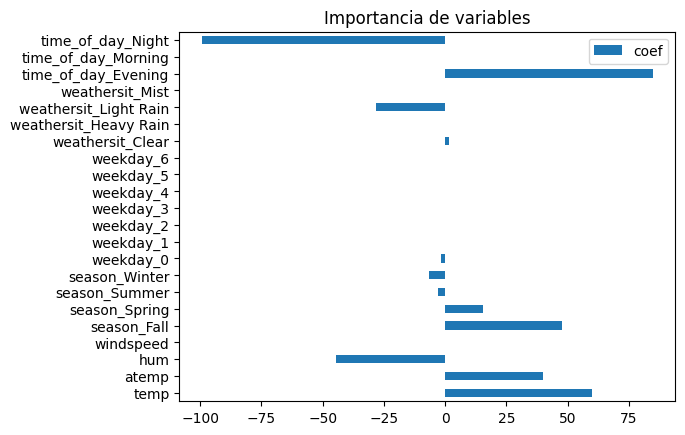

In [189]:
pd.DataFrame(modelo_lasso["regressor"].coef_, index = final_features, columns = ["coef"]).plot(kind = "barh")
plt.title("Importancia de variables")
plt.show()

Ecuación final incluyendo coeficientes con 0

$$
\hat{y} = 59.963\,\text{temp} \;+\; 39.935\,\text{atemp} \;-\; 44.702\,\text{hum} \;+\; 0\,\text{windspeed} \;+\; 47.749\,\text{season\_Fall} \;+\; 15.323\,\text{season\_Spring} \;-\; 3.095\,\text{season\_Summer} \;-\; 6.689\,\text{season\_Winter} \;-\; 1.819\,\text{weekday\_0} \;+\; 0\,\text{weekday\_1} \;+\; 0\,\text{weekday\_2} \;+\; 0\,\text{weekday\_3} \;+\; 0\,\text{weekday\_4} \;+\; 0\,\text{weekday\_5} \;+\; 0\,\text{weekday\_6} \;+\; 1.525\,\text{weathersit\_Clear} \;+\; 0\,\text{weathersit\_Heavy Rain} \;-\; 28.106\,\text{weathersit\_Light Rain} \;+\; 0\,\text{weathersit\_Mist} \;+\; 84.704\,\text{time\_of\_day\_Evening} \;+\; 0\,\text{time\_of\_day\_Morning} \;-\; 99.357\,\text{time\_of\_day\_Night}\;+\;193.15
$$

Ecuación final excluyendo coeficientes con 0

$$
\hat{y} = 59.963\,\text{temp} \;+\; 39.935\,\text{atemp} \;-\; 44.702\,\text{hum} \;+\; 47.749\,\text{season\_Fall} \;+\; 15.323\,\text{season\_Spring} \;-\; 3.095\,\text{season\_Summer} \;-\; 6.689\,\text{season\_Winter} \;-\; 1.819\,\text{weekday\_0} \;+\; 1.525\,\text{weathersit\_Clear} \;-\; 28.106\,\text{weathersit\_Light Rain} \;+\; 84.704\,\text{time\_of\_day\_Evening} \;-\; 99.357\,\text{time\_of\_day\_Night}\;+\;193.15
$$



**Conclusiones**

Las conclusiones de los coeficientes son bastante interesantes. Por ejemplo, se puede ver que, a pesar de lo que se pueda pensar, temperaturas extremas (`summer` y `winter`) llevan a una disminución de la cantidad de alquileres de bicicletas. Alquilar en verano reduce en 3.095 en promedio el número de bicicletas alquiladas en ese día, mientras que en invierno se reduce en 6.689 en promedio. Asimismo, la temporada que hace que se alquilen más bicicletas es `fall`, lo que se puede explicar por temperaturas más templadas e inicio de año académico en las universidades. Asimismo, aumentar un grado la temperatura hace que el número de bicicletas alquiladas aumente en 59.963 en promedio, manteniendo todo lo demás constante. Lo interesante es que a mayor humedad, menor cantidad de bicicletas alquiladas (1% más de humendad conlleva a una reducción en la predicción de bicicletas alquiladas de 44.702 en promedio).

Asimismo, se puede ver que el único coeficiente diferente a 0 de la variable `weekday` es el que pertenece al día 0 (asumiendo que es domingo), lo que indica que el hecho de que sea domingo disminuye el número de bicicletas alquiladas en 1.8 en promedio. Igualmente, tal como se esperaba, que haya un clima despejado (`weathersit = Clear`) hace que el número de bicicletas alquiladas aumente en 1.5 en promedio, mientras que una ligera lluvía hace que el número caiga en 28 en promedio. Otros tipos de clima no afectan la predicción. Finalmente, la variable que más influye en la predicción es el tiempo del día `time_of_day`, haciendo que el alquiler de bicicletas aumente en 84 unidades en promedio cuando es de tarde, mientras que si es de noche este se reduce en 99 unidades en promedio. Otros momentos del día no afectan la predicción.

Entonces, en conclusión, en base a los coeficientes, las variables que más afectan la predicción (más importantes) según el modelo Lasso escogido son `time_of_day` (siendo los valores `Night` y `Evening` los más relevantes), la temperatura (tanto la real como la sensación), y la humedad. Finalmente, la estación del año (el que el alquiler sea en `Fall`) influye en la predicción.